# Classification & Generation of Hand Drawn Tree Symbols

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

import torchvision.transforms as transforms
import torchvision.datasets as datasets

import matplotlib.pyplot as plt

from PIL import Image

import numpy as np
import math

## Dataset Exploration

Extract the zip file & tidy up the resulting folder

In [3]:
image_folder = "symbols_dataset_3"
datasets.utils.extract_archive("symbols_dataset.zip", image_folder)
!rm $image_folder/__MACOSX -r

Create dataset

In [4]:
transform = transforms.Compose([transforms.Grayscale(num_output_channels=1), # Ensure image is greyscale, and not RGB where each channel is equal
                                transforms.Lambda(lambda x: transforms.functional.invert(x)), # Invert such that the background is 0, and the brushstrokes are 1
                                transforms.ToTensor()]) # Transform to tensor
dataset = datasets.ImageFolder(image_folder, transform=transform)

Check dataset distribution

16828 total datapoints


<BarContainer object of 5 artists>

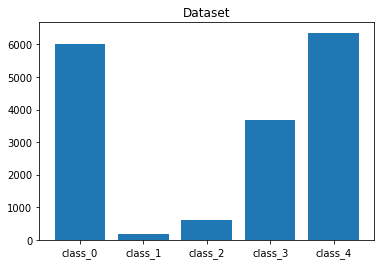

In [5]:
_, class_counts = np.unique(dataset.targets, return_counts=True)
print(sum(class_counts), "total datapoints")
plt.title("Dataset")
plt.bar(dataset.classes, class_counts)

It's not balanced, so we'll use a weighted random sampler in our training data loader, to avoid the model under-predicting classes 1 or 2.  In addition, we'll want to use this in our validation data loader, as we know the testing dataset will be balanced.

To avoid the oversampling of the classes causing biases, we'll augment the data with some random transformations to the datapoints too, so that datapoints are unlikely to be identical when oversampled.

Make a dataloader and visualise the data.

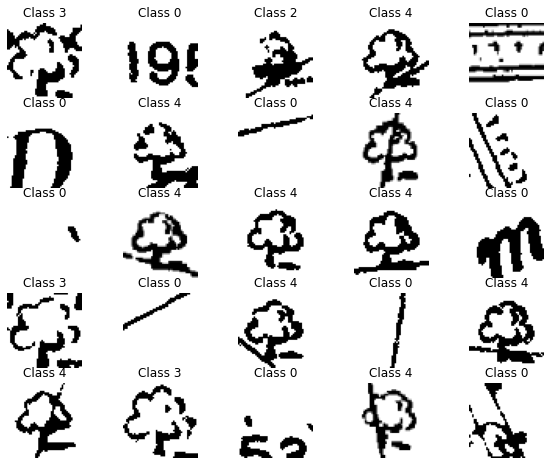

In [6]:
data_loader = torch.utils.data.DataLoader(dataset, batch_size=25, shuffle=True)


images, labels = next(iter(data_loader))

figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(cols * rows):
    figure.add_subplot(rows, cols, i+1)
    plt.title(f"Class {labels[i].item()}")
    plt.axis("off")
    plt.imshow(-images[i,:].squeeze(), cmap="gray")
plt.show()

The datapoints are all rather visually similar.  The data augmentation will help change this, meaning that the model should still hold up in the event that the test data is not as homogeneous.

## Dataset Processing

Time to create the dataset we'll be using, and set up the following transformations that will augment the dataset:


1.   A random rotation of 0-360°, in which the image may be expanded beyond the 48x48 original shape
2.   Random changes of brightness, contrast, and saturation all by factors of between 0 and 0.5
3.   A 50% chance of a horizontal flip being applied
4.   A 50% chance of a vertical flip being applied
5.   A centre crop back down to a size of 48x48.


These transformations will introduce variation in the dataset whilst maintaining the approximate centre alignement of the symbols and the scale of the images, both of which are discussed in the dataset's description.

In [7]:
transform = transforms.Compose([transforms.Grayscale(num_output_channels=1), # Ensure image is greyscale, and not RGB where each channel is equal
                                transforms.Lambda(lambda x: transforms.functional.invert(x)), # Invert such that the background is 0, and the brushstrokes are 1
                                transforms.RandomRotation(360, expand=True),
                                transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
                                transforms.RandomHorizontalFlip(0.5),
                                transforms.RandomVerticalFlip(0.5),
                                transforms.CenterCrop(48),
                                transforms.ToTensor()]) # Transform to tensor
dataset = datasets.ImageFolder(image_folder, transform=transform)

Split the data into training and validation datasets, with the validation dataset containing 20% of the full dataset, and the training dataset containing the remaining 80%.

In [8]:
val_data_proportion = 0.2
train_data, val_data = torch.utils.data.random_split(dataset, [1-val_data_proportion, val_data_proportion])

Create class weights based on the frequency of each class in the dataset

In [9]:
class_weights = [sum(class_counts) / c for c in class_counts]
class_weights

[2.804666666666667,
 92.97237569060773,
 27.768976897689768,
 4.56662143826323,
 2.647577092511013]

Create sample weights from the class weights, and use these to make samplers that create a balanced sample the same size as the unbalanced training and validation datasets.

In [10]:
# Calculate sample weights for training data
sample_weights = [0] * len(train_data)
for idx, (image, label) in enumerate(train_data):
    class_weight = class_weights[label]
    sample_weights[idx] = class_weight

# Use to create sampler
train_sampler = WeightedRandomSampler(sample_weights, len(sample_weights))

# Calculate sampler weights for validation data
sample_weights = [0] * len(val_data)
for idx, (image, label) in enumerate(val_data):
    class_weight = class_weights[label]
    sample_weights[idx] = class_weight

# Use to create sampler
val_sampler = WeightedRandomSampler(sample_weights, len(sample_weights))

Use the samplers to create dataloaders for both datasets.  These will have a batch size of 100, as smaller batch sizes resulted in unstable values for the loss function and classification accuracy.

In [11]:
batch_size=100

# Create data loaders for each using their respective sampler
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, sampler=val_sampler)

Let's inspect the class distribution of a batch from each loader to ensure it is balanced:

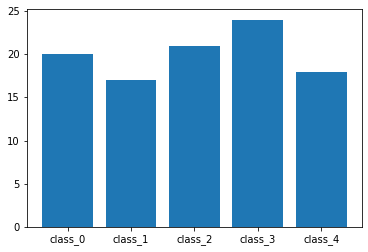

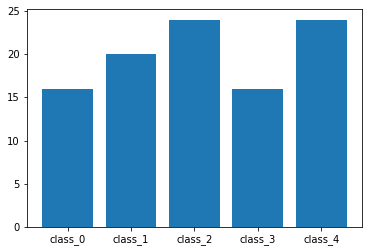

In [12]:
images, labels = next(iter(train_loader))
class_labels, class_c = np.unique(labels, return_counts=True)
plt.bar(dataset.classes, class_c)
plt.show()

images, labels = next(iter(val_loader))
class_labels, class_c = np.unique(labels, return_counts=True)
plt.bar(dataset.classes, class_c)
plt.show()

Let's check the data we get from the training data loader to ensure everything's looking good

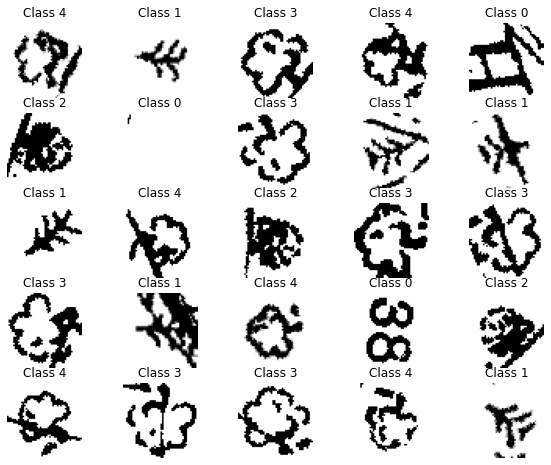

In [13]:
images, labels = next(iter(train_loader))

figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(cols * rows):
    figure.add_subplot(rows, cols, i+1)
    plt.title(f"Class {labels[i].item()}")
    plt.axis("off")
    plt.imshow(-images[i,:].squeeze(), cmap="gray")
plt.show()

The data looks good, time to build a model.

## My CNN

My CNN is based on a previous CNN used on the MNIST dataset (MiniVGG).  Both the MNIST and tree symbols datasets are handwritten/handdrawn and (mostly) either pure black or white, with only small elements of greyscale, making them rather similar.

My implementation of MiniVGG was structured as follows:

* 1st phase
  *   Convolution (1 channel -> 6)
  *   ReLU
  *   Convolution (6 channels -> 6)
  *   ReLU
  *   Max pooling
* 2nd phase
  *   Convolution (6 channels -> 10)
  *   ReLU
  *   Convolution (10 channels -> 10)
  *   ReLU
  *   Max pooling
* 3rd phase 
  *   Fully connected (490 features -> 120)
  *   ReLU
  *   Fully connected (120 features -> 84)
  *   ReLU
  *   Fully connected (84 features -> 10)

There is much more noticable variation in the dataset of MNIST than there is in the tree symbol dataset, and as such the MiniVGG model was uneccesarily complex for this dataset.  The model used for the tree symbol dataset (SimpleCNN) is simpler than MiniVGG, although it does include batch normalisation - as this is known to improve performance.

The full structure of SimpleCNN is as follows:
* 1st phase
  *   Convolution (1 channel -> 6)
  *   Batch normalisation
  *   ReLU
  *   Max pooling
* 2nd Phase
  *   Convolution (6 channels -> 10)
  *   Batch normalisation
  *   ReLU
  *   Max pooling
* 3rd phase
  *   Fully connected (1440 features -> 120)
  *   ReLU
  *   Fully connected (120 features -> 84)
  *   ReLU
  *   Fully connected (84 features -> 5)



In [14]:
class SimpleCNN(nn.Module):
  def __init__(self):
    super(SimpleCNN, self).__init__()

    self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3, stride=1, padding=1)
    self.bn1 = nn.BatchNorm2d(6)
    self.relu = nn.ReLU()
    self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv2 = nn.Conv2d(in_channels=6, out_channels=10, kernel_size=3, stride=1, padding=1)
    self.bn2 = nn.BatchNorm2d(10)

    self.fc1 = nn.Linear(in_features=12*12*10,out_features=120)
    self.fc2 = nn.Linear(in_features=120,out_features=84)
    self.fc3 = nn.Linear(in_features=84,out_features=5)  

  def forward(self, x):
    # Input has dimensions (B is batch size):
    # B x  1 x 48 x 48
    x = self.conv1(x)
    # B x  6 x 48 x 48
    x = self.bn1(x)
    x = self.relu(x)
    x = self.maxpool(x)
    # B x  6 x 24 x 24

    x = self.conv2(x)
    # B x 10 x 24 x 24
    x = self.bn2(x)
    x = self.relu(x)
    x = self.maxpool(x)
    # B x 10 x 12 x 12

    x = x.view(x.size(0), -1)
    # Flattened to B x 10*12*12
    x = self.fc1(x)
    # B x 120
    x = self.relu(x)
    x = self.fc2(x)
    # B x 84
    x = self.relu(x)
    x = self.fc3(x)
    # B x 5
    return x

model = SimpleCNN()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Model: SimpleCNN\nDevice:", device)
model = model.to(device)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("No. Params:", total_params)
print("No. Pixels in Dataset:", len(dataset)*48*48)

Model: SimpleCNN
Device: cuda
No. Params: 184151
No. Pixels in Dataset: 38771712


As we can see, the number of parameters is significatnly smaller than the number of pixels in the dataset, which suggests we should not see memorisation of the dataset.


Use cross entropy loss as the loss function, as it can handle any number of classes

In [15]:
loss_func = nn.CrossEntropyLoss()

## Training

Train the model, with the following hyperparameters:


*   Number of epochs = 10, as the model can learn from the dataset rather quickly.
*   Learning rate = 0.01, as I have used this successfully in the past, and found no need to change it.



In [16]:
num_epochs = 10

# Set up the optimiser
optim = torch.optim.Adam(model.parameters(), lr = 0.01)

# Initialise some variables for computing and tracking stats
iterations_per_epoch = math.ceil(len(train_data)/batch_size)
training_losses = []
training_accuracies = []
testing_losses = []
testing_accuracies = []
for epoch in range(num_epochs):

  # One epoch on the training set
  total_loss = 0
  correct = 0
  total = 0
  total_loss = 0
  for i, (inputs, labels) in enumerate(train_loader):
    inputs, labels = inputs.to(device), labels.to(device)
    # Pass mini-batch through model
    output = model(inputs)
    loss = loss_func(output,labels)
    optim.zero_grad()
    loss.backward()
    optim.step()
    # Find the predicted classes and check accuracy
    pred_y = torch.argmax(output, 1)
    correct += (pred_y == labels).sum()
    total += float(labels.size(0))
    total_loss += loss*images.shape[0]
    if (i+1) % 50 == 0:
       print('Epoch [{}/{}], Iteration [{}/{}], Training Loss: {:.4f}'.format(epoch + 1, num_epochs, i + 1, iterations_per_epoch, loss.item()))
  total_loss /= len(train_data)
  training_losses.append(total_loss.item())
  training_accuracies.append((correct/total).cpu())
  print('Train accuracy over epoch {}: {:.4f}'.format(epoch+1,training_accuracies[-1]))

  # One epoch on the test set
  correct = 0
  total = 0
  # Switch to evaluation mode
  model.eval()
  with torch.no_grad():
    for images, labels in val_loader:
      images, labels = images.to(device), labels.to(device)
      output = model(images)
      loss = loss_func(output,labels)
      pred_y = torch.argmax(output, 1)
      correct += (pred_y == labels).sum()
      total += float(labels.size(0))
      total_loss += loss*images.shape[0]
    test_accuracy = correct/total 
  total_loss /= len(val_data)
  testing_losses.append(total_loss.item()) 
  # Switch back to training mode
  model.train()
  testing_accuracies.append(test_accuracy.cpu())
  print('Val accuracy at epoch {}: {:.4f}, Val loss: {:.4f}'.format(epoch+1, test_accuracy, loss.item()))

Epoch [1/10], Iteration [50/135], Training Loss: 0.2079
Epoch [1/10], Iteration [100/135], Training Loss: 0.0934
Train accuracy over epoch 1: 0.8576
Val accuracy at epoch 1: 0.9483, Val loss: 0.1625
Epoch [2/10], Iteration [50/135], Training Loss: 0.1529
Epoch [2/10], Iteration [100/135], Training Loss: 0.0876
Train accuracy over epoch 2: 0.9599
Val accuracy at epoch 2: 0.9685, Val loss: 0.0691
Epoch [3/10], Iteration [50/135], Training Loss: 0.0679
Epoch [3/10], Iteration [100/135], Training Loss: 0.1856
Train accuracy over epoch 3: 0.9681
Val accuracy at epoch 3: 0.9712, Val loss: 0.0289
Epoch [4/10], Iteration [50/135], Training Loss: 0.0327
Epoch [4/10], Iteration [100/135], Training Loss: 0.1922
Train accuracy over epoch 4: 0.9738
Val accuracy at epoch 4: 0.9721, Val loss: 0.1376
Epoch [5/10], Iteration [50/135], Training Loss: 0.0297
Epoch [5/10], Iteration [100/135], Training Loss: 0.0957
Train accuracy over epoch 5: 0.9774
Val accuracy at epoch 5: 0.9682, Val loss: 0.1433
Epoch

Let's see how the model performed:

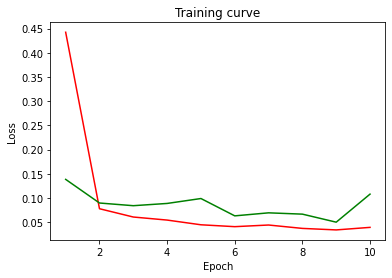

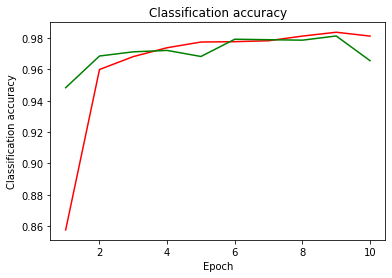

In [17]:
plt.title("Training curve")
plt.plot(range(1, len(training_losses)+1),training_losses,'r')
plt.plot(range(1, len(testing_losses)+1),testing_losses,'g')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

plt.title("Classification accuracy")
plt.plot(range(1, len(training_accuracies)+1),training_accuracies,'r')
plt.plot(range(1, len(testing_accuracies)+1),testing_accuracies,'g')
plt.xlabel("Epoch")
plt.ylabel("Classification accuracy")
plt.show()

The graphs show a strong classification accuracy.

## Weight saving

Save the weights to the required file

In [18]:
torch.save(model.state_dict(), 'weights.pkl')

Test that we can load the weights and run the model to get the correct predictions.

In [19]:
import classify_symbols

print("Same predictions:")
model.eval()
for images, labels in val_loader:
  output_script = classify_symbols.classify(images)
  output_model = torch.argmax(model(images.to(device)), 1).to("cpu")
  print((sum(output_model - output_script) == 0).item())

Same predictions:
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


# Generating tree symbol images of specified class

In [58]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import matplotlib.pyplot as plt

import numpy as np
import math

In [59]:
image_folder = "symbols_dataset_4"
datasets.utils.extract_archive("symbols_dataset.zip", image_folder)
!rm $image_folder/__MACOSX -r

In [60]:
# We must discard the background class, so I will remove it from the dataset.
!rm $image_folder/class_0 -r

## Dataset Processing

Since we don't need a validation set for a GAN, we'll create a new dataset using all the images for this section.  We will not augment the dataset in any way, as I wish to generate images as close to the original dataset as possible.

In [61]:
transform = transforms.Compose([transforms.Grayscale(num_output_channels=1), # Ensure image is greyscale, and not RGB where each channel is equal
                                transforms.ToTensor(), # Transform to tensor
                                transforms.Lambda(lambda x: transforms.functional.invert(x)), # Invert such that the background is 0, and the brushstrokes are 1
                                transforms.Normalize(0.5, 0.5)]) # Normalise the data to be between -1 and 1

dataset = datasets.ImageFolder(image_folder, transform=transform)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

We will once again need to balance the dataset, so we must create class weights based on the frequency of each class in the dataset.

In [62]:
_, class_counts = np.unique(dataset.targets, return_counts=True)
class_weights = [sum(class_counts) / c for c in class_counts]
class_weights

[59.8232044198895, 17.86798679867987, 2.9383989145183174, 1.7035871617369416]

And again create sample weights from the class weights, using them to make a sampler and a dataloader.

In [63]:
batch_size = 100

# Calculate sample weights for data
sample_weights = [0] * len(dataset)
for idx, (image, label) in enumerate(dataset):
    class_weight = class_weights[label]
    sample_weights[idx] = class_weight

# Use to create sampler
# (Dataset size does not divide neatly into batch size, but needs to for these
#  models, so we simply increase the size to the next multiple of batch size.)
sampler = WeightedRandomSampler(sample_weights, math.ceil(len(sample_weights)/batch_size)*batch_size)

# Create data loader using the sampler
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=sampler)

Let's inspect the class distribution of a batch from the loader to ensure it's balanced:

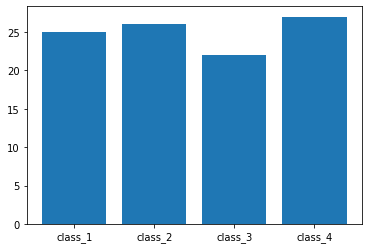

In [64]:
images, labels = next(iter(dataloader))
class_labels, class_c = np.unique(labels, return_counts=True)
plt.bar(dataset.classes, class_c)
plt.show()

Let's check the data we get from the training data loader to ensure everything's looking good:

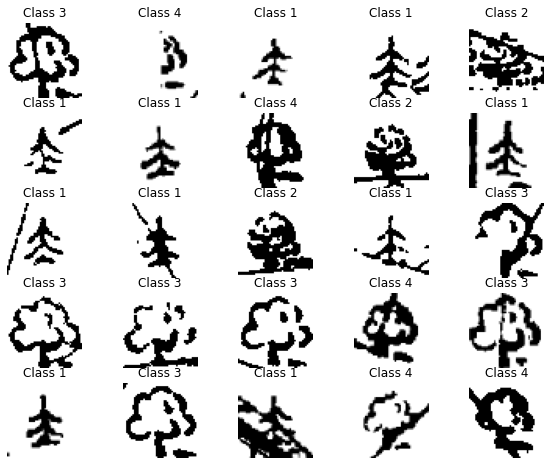

In [65]:
images, labels = next(iter(dataloader))

figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(cols * rows):
    figure.add_subplot(rows, cols, i+1)
    plt.title(f"Class {labels[i].item()+1}")
    plt.axis("off")
    plt.imshow(-images[i,:].squeeze(), cmap="gray")
plt.show()

Everything looks fine, time to create the models.

## Discriminator

The discriminator is based on the CNN created for question 3 (SimpleCNN), and a conditional discriminator previosuly created for generating images for a specified class from the Fashion MNIST dataset, a more complex and varied dataset than this dataset.

Comparing the discriminator to SimpleCNN, we can see that the discriminator makes use of Leaky ReLU instead of regular ReLU, as it is better suited to use in GANs.  The discriminator also drops the Max Pooling layers, the size of the datapoints are instead reduced by the convolution layers - which led to great results in the discriminator for Fashion MNIST.

The full design of the discriminator is as follows:

* Code to turn the labels for each image into an additional channel
* 1st phase:
  * Convolution (1 channel -> 64)
  * Batch normalisation
  * Leaky ReLU
* 2nd phase:
  * Convolution (64 channels -> 128)
  * Batch normalisation
  * Leaky ReLU
* 3rd phase:
  * Convolution (128 channels -> 256)
  * Batch normalisation
  * Leaky ReLU
  * Convolution (256 channels -> 1)

In [66]:
ndf = 64
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.embedding = torch.nn.Embedding(10, 50)
    self.upscale = nn.Linear(50, 48*48)
    
    self.conv1 = nn.Conv2d(2, ndf, 4, 2, 1, bias=False)
    self.bn1 = nn.BatchNorm2d(ndf)
    self.relu = nn.LeakyReLU(0.2, inplace=True)

    self.conv2 = nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False)
    self.bn2 = nn.BatchNorm2d(ndf * 2)

    self.conv3 = nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False)
    self.bn3 = nn.BatchNorm2d(ndf * 4)

    self.conv4 = nn.Conv2d(ndf * 4, 1, 6, 1, 0, bias=False)
        

  def forward(self, input, labels):
    # Turn the labels into part of the data
    labels = self.embedding(labels)
    labels = self.upscale(labels)
    labels = labels.view(-1, 48, 48)
    labels = labels.unsqueeze(1)

    x = torch.cat((input, labels), 1)

    # Input has size (B is batch size):
    # B x 2 x 48 x 48
    x = self.conv1(x)
    # B x (ndf) x 24 x 24
    x = self.bn1(x)
    x = self.relu(x)

    x = self.conv2(x)
    # B x (ndf*2) x 12 x 12
    x = self.bn2(x)
    x = self.relu(x)

    x = self.conv3(x)
    # B x (ndf * 4) x 6 x 6
    x = self.bn3(x)
    x = self.relu(x)

    x = self.conv4(x)
    # B x 1 x 1 x 1

    return x
netD = Discriminator()
netD = netD.to(device)

total_params = sum(p.numel() for p in netD.parameters() if p.requires_grad)
print("No. Params:", total_params)

No. Params: 785524


## Generator

The generator is based on a conditional generator used originally on the Fashion MNIST dataset.  The structure of the generator is as follows:

* Code to turn the given label into an additional 50 values in the latent vector, resulting in a total of 150 values.
* 1st phase:
  * Convolution (150 channels -> 256)
  * Batch normalisation
  * ReLU
* 2nd phase:
  * Convolution (256 channels -> 128)
  * Batch normalisation
  * ReLU
* 3rd phase:
  * Convolution (128 channels -> 64)
  * Batch normalisation
  * ReLU
* 4th phase:
  * Convolution (64 channels -> 1)
  * Hyperbolic Tangent

Hyperbolic Tangent is used as it will ensure all the values are between -1 and 1.  A latent vector size of 100 had worked well previously on Fashion MNIST, and has worked well on this dataset, and as such has not been changed.  The same applies for the number of channels in the convolution layers, where the only cahnges have been in order to produce the correct dimensions for the images.

In [67]:
nz = 100 # Size of z latent vector (i.e. size of generator input)
ngf = 64

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.embedding = torch.nn.Embedding(10, 50)
        
        self.conv1 = nn.ConvTranspose2d( nz+50, ngf * 4, 6, 1, 0, bias=False)
        self.bn1 = nn.BatchNorm2d(ngf * 4)
        self.relu = nn.ReLU(True)
        self.conv2 = nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(ngf * 2)
        self.conv3 = nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(ngf)
        self.conv4 = nn.ConvTranspose2d( ngf, 1, 4, 2, 1, bias=False)
        self.tanh = nn.Tanh()
        

    def forward(self, input, labels):
        labels = self.embedding(labels).unsqueeze(2).unsqueeze(2)
        x = torch.cat((input, labels), 1)

        # input is Z of size B x nz+50 x 1 x 1, we put this directly into a transposed convolution
        x = self.conv1(x)
        # B x (ngf*4) x 6 x 6
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        # B x (ngf*2) x 12 x 12
        x = self.bn2(x)
        x = self.relu(x)

        x = self.conv3(x)
        # B x ngf x 24 x 24
        x = self.bn3(x)
        x = self.relu(x)
        
        x = self.conv4(x)
        # B x 1 x 48 x 48
        x = self.tanh(x)
        return x

netG = Generator()
netG = netG.to(device)

total_params = sum(p.numel() for p in netG.parameters() if p.requires_grad)
print("No. Params:", total_params)

No. Params: 2040180


## Training

The number of epochs during development was set to 30, as this is approximately where the images become clear, however for the purposes of demonstration, I have set the number of epochs to 100, in order to hopefully achieve better images.  The learning rate and the hyperparameter for Adam optimizers have been left at the values used previously on the Fashion MNIST dataset, as I have not felt I needed to adjust them.

In order to improve performance, my loss functions have been changed to Wasserstein Loss.  In a Wasserstein GAN the discriminator should output 1 on fake images, and -1 on real images.  The loss functions, which both models are expected to maximize, are as follows:
* Discriminator: mean\[discriminator(real images) - discriminator(generated images)]
* Generator: mean\[discriminator(generated images)]

Starting Training Loop...
[1/100]	Loss_D: 0.4955	Loss_G: -0.2802


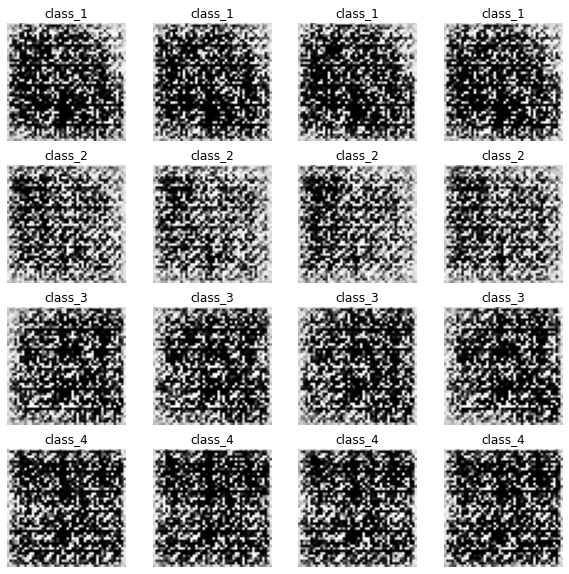

[2/100]	Loss_D: 0.4699	Loss_G: -0.3689
[3/100]	Loss_D: 0.3912	Loss_G: -0.1704
[4/100]	Loss_D: 0.4944	Loss_G: -0.4138
[5/100]	Loss_D: 0.5806	Loss_G: -0.3487
[6/100]	Loss_D: 0.5978	Loss_G: -0.4290


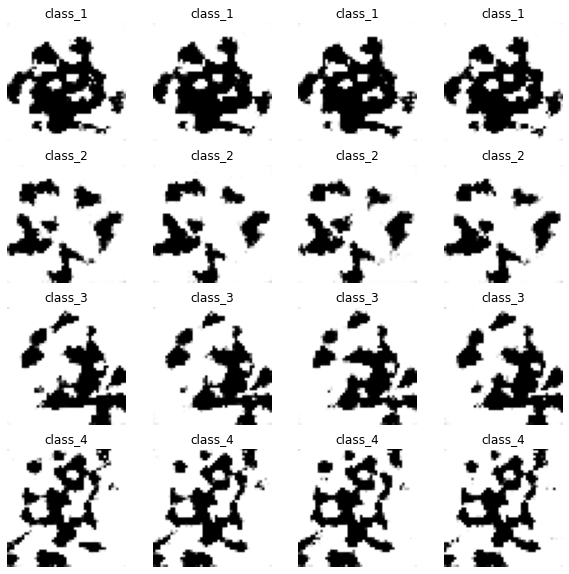

[7/100]	Loss_D: 0.6234	Loss_G: -0.5099
[8/100]	Loss_D: 0.5902	Loss_G: -0.2588
[9/100]	Loss_D: 0.4972	Loss_G: -0.3245
[10/100]	Loss_D: 0.4750	Loss_G: -0.2261
[11/100]	Loss_D: 0.4308	Loss_G: -0.0782


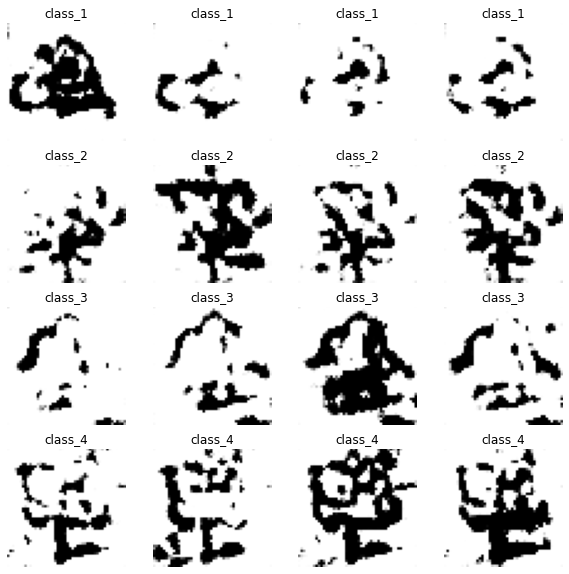

[12/100]	Loss_D: 0.4997	Loss_G: -0.4290
[13/100]	Loss_D: 0.4806	Loss_G: -0.3003
[14/100]	Loss_D: 0.4039	Loss_G: -0.1300
[15/100]	Loss_D: 0.4740	Loss_G: -0.3192
[16/100]	Loss_D: 0.3870	Loss_G: -0.2355


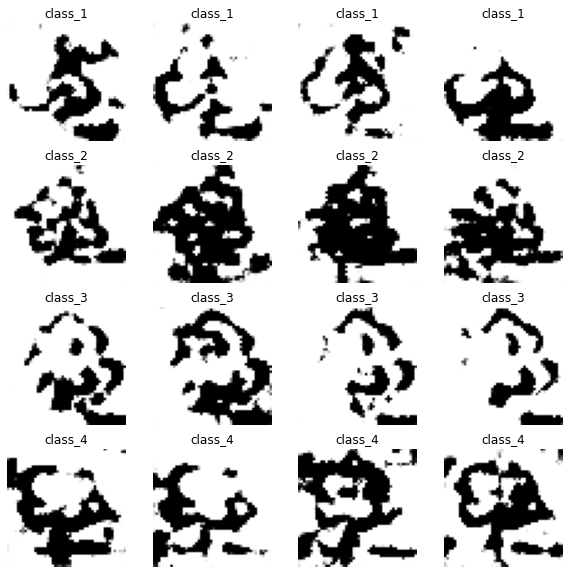

[17/100]	Loss_D: 0.3296	Loss_G: -0.1367
[18/100]	Loss_D: 0.4192	Loss_G: -0.1967
[19/100]	Loss_D: 0.3917	Loss_G: -0.2326
[20/100]	Loss_D: 0.3363	Loss_G: -0.2646
[21/100]	Loss_D: 0.3115	Loss_G: -0.2844


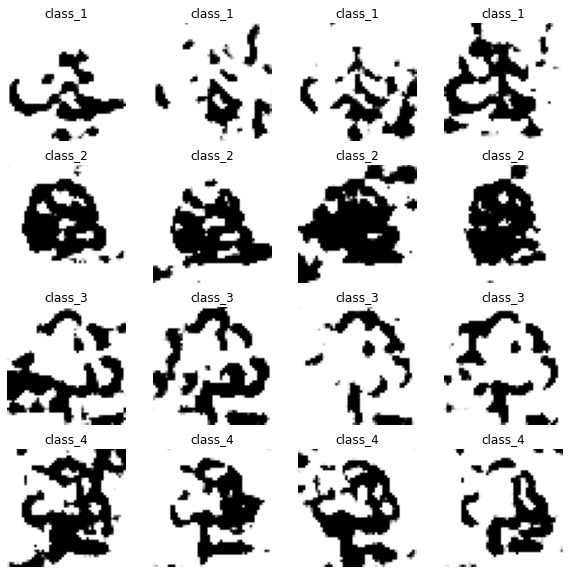

[22/100]	Loss_D: 0.3123	Loss_G: -0.2475
[23/100]	Loss_D: 0.3661	Loss_G: -0.3244
[24/100]	Loss_D: 0.3280	Loss_G: -0.1838
[25/100]	Loss_D: 0.3199	Loss_G: -0.1190
[26/100]	Loss_D: 0.2821	Loss_G: -0.2323


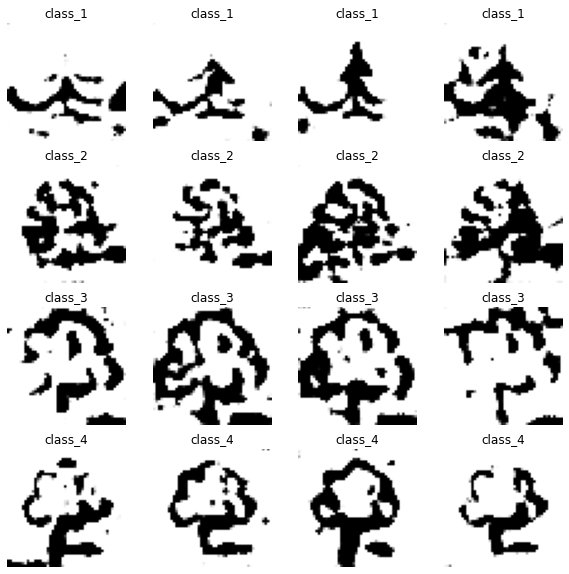

[27/100]	Loss_D: 0.3045	Loss_G: -0.1671
[28/100]	Loss_D: 0.3413	Loss_G: 0.0961
[29/100]	Loss_D: 0.2928	Loss_G: -0.2245
[30/100]	Loss_D: 0.1271	Loss_G: -0.2471
[31/100]	Loss_D: 0.2721	Loss_G: -0.1080


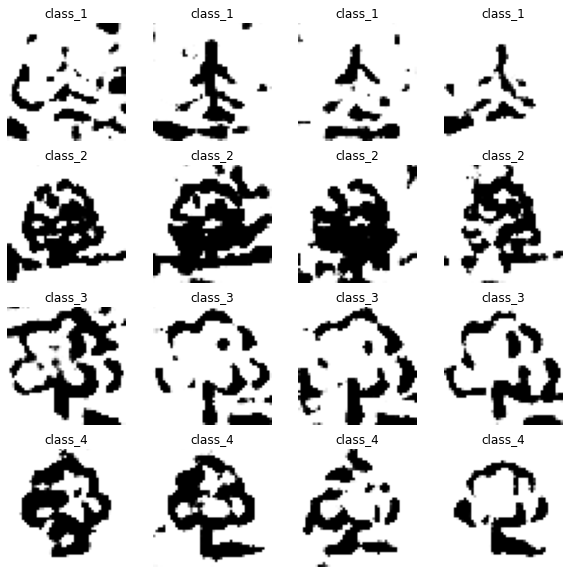

[32/100]	Loss_D: 0.4446	Loss_G: -0.3132
[33/100]	Loss_D: 0.2145	Loss_G: -0.1400
[34/100]	Loss_D: 0.3238	Loss_G: -0.3975
[35/100]	Loss_D: 0.5625	Loss_G: -0.5273
[36/100]	Loss_D: 0.3200	Loss_G: -0.4542


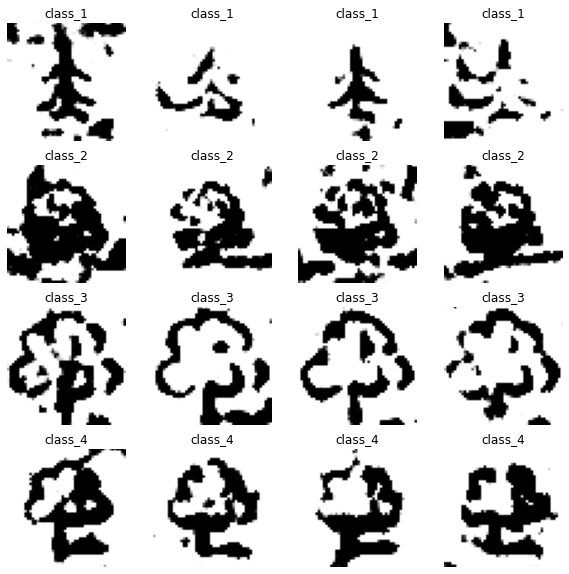

[37/100]	Loss_D: 0.3475	Loss_G: 0.1770
[38/100]	Loss_D: 0.3104	Loss_G: -0.3672
[39/100]	Loss_D: 0.4420	Loss_G: -0.3069
[40/100]	Loss_D: 0.0541	Loss_G: 0.4890
[41/100]	Loss_D: 0.3852	Loss_G: -0.4429


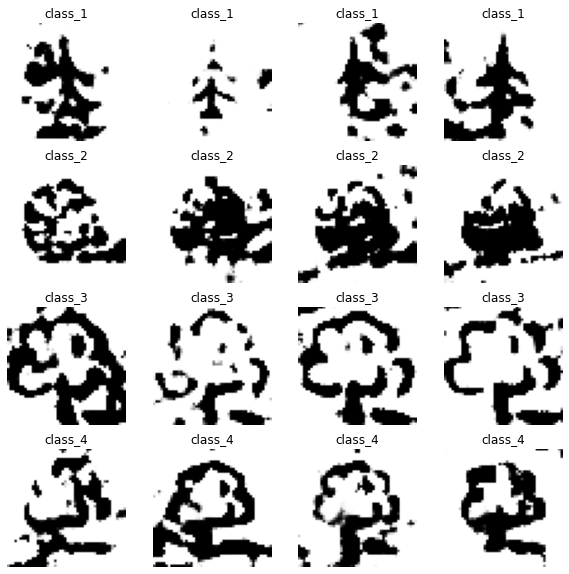

[42/100]	Loss_D: 0.3670	Loss_G: -0.4236
[43/100]	Loss_D: 0.4327	Loss_G: -0.4364
[44/100]	Loss_D: 0.3351	Loss_G: -0.3673
[45/100]	Loss_D: 0.3519	Loss_G: -0.1678
[46/100]	Loss_D: 0.3600	Loss_G: -0.3660


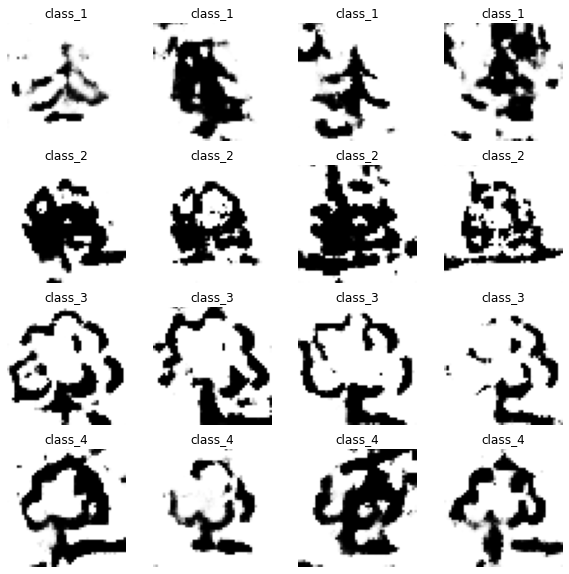

[47/100]	Loss_D: 0.2721	Loss_G: -0.1127
[48/100]	Loss_D: 0.2883	Loss_G: -0.0976
[49/100]	Loss_D: 0.3773	Loss_G: -0.2671
[50/100]	Loss_D: 0.2698	Loss_G: -0.4055
[51/100]	Loss_D: 0.2336	Loss_G: -0.1291


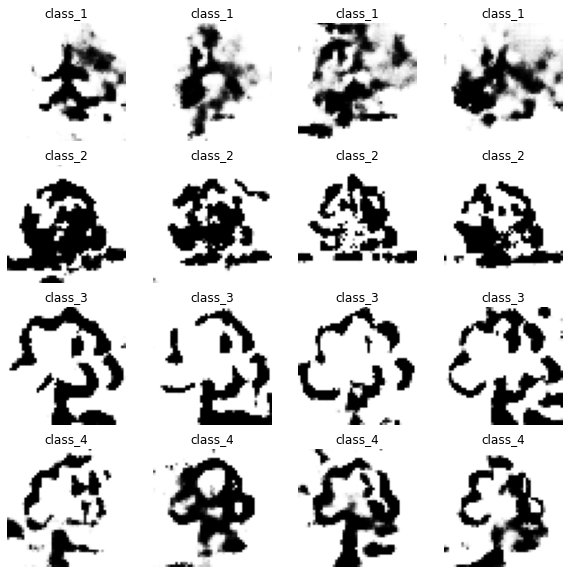

[52/100]	Loss_D: 0.3165	Loss_G: -0.2140
[53/100]	Loss_D: 0.3971	Loss_G: -0.0536
[54/100]	Loss_D: 0.3856	Loss_G: -0.1901
[55/100]	Loss_D: 0.2255	Loss_G: -0.0605
[56/100]	Loss_D: 0.3255	Loss_G: -0.2320


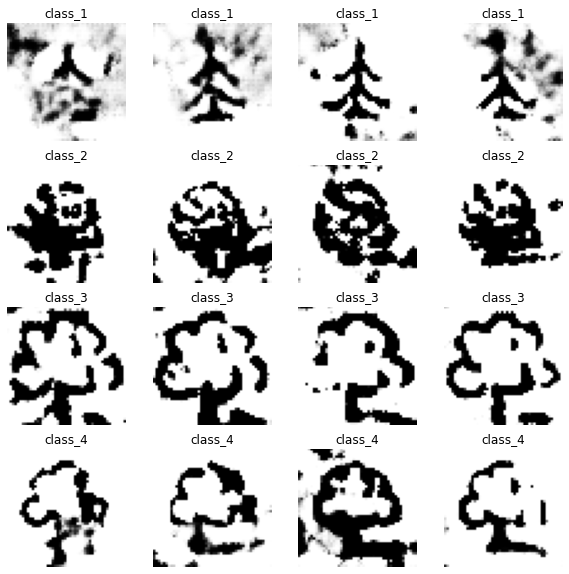

[57/100]	Loss_D: 0.2446	Loss_G: -0.3795
[58/100]	Loss_D: 0.2841	Loss_G: -0.2145
[59/100]	Loss_D: 0.2999	Loss_G: -0.1719
[60/100]	Loss_D: 0.2554	Loss_G: 0.0287
[61/100]	Loss_D: 0.1766	Loss_G: -0.1440


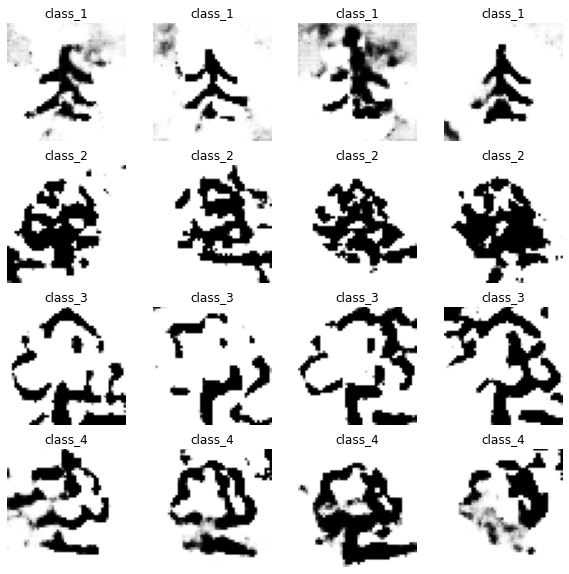

[62/100]	Loss_D: 0.2449	Loss_G: -0.2760
[63/100]	Loss_D: 0.2369	Loss_G: -0.1505
[64/100]	Loss_D: 0.2927	Loss_G: -0.1905
[65/100]	Loss_D: 0.2899	Loss_G: -0.2841
[66/100]	Loss_D: 0.2501	Loss_G: -0.1413


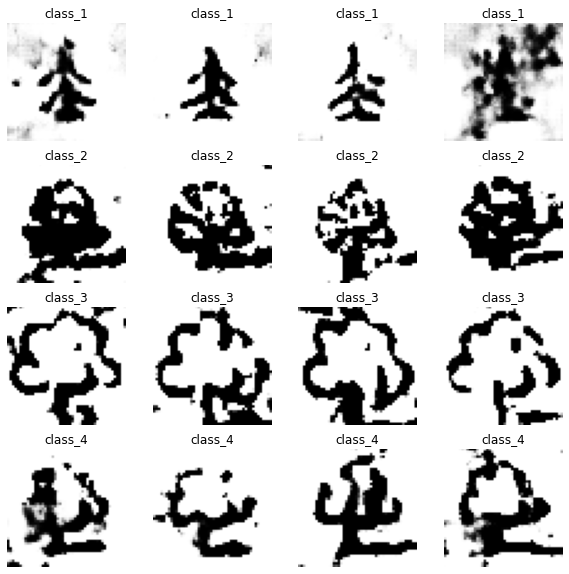

[67/100]	Loss_D: 0.2241	Loss_G: -0.0272
[68/100]	Loss_D: 0.2769	Loss_G: -0.2556
[69/100]	Loss_D: 0.2919	Loss_G: -0.3208
[70/100]	Loss_D: 0.2820	Loss_G: -0.1420
[71/100]	Loss_D: 0.2576	Loss_G: -0.1573


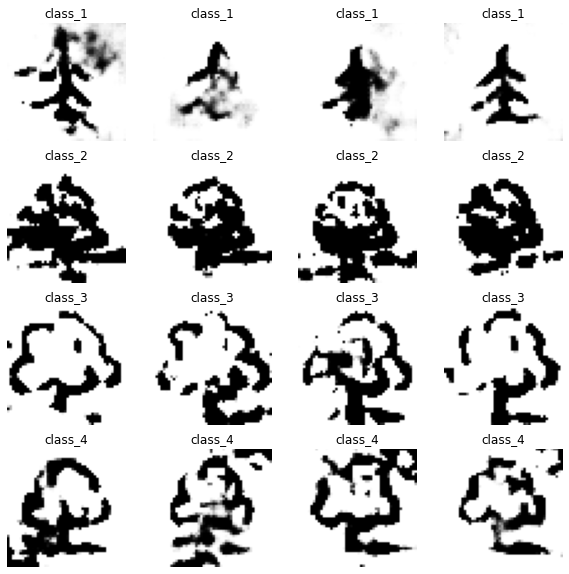

[72/100]	Loss_D: 0.2964	Loss_G: -0.4175
[73/100]	Loss_D: 0.2414	Loss_G: -0.2296
[74/100]	Loss_D: 0.2275	Loss_G: -0.2084
[75/100]	Loss_D: 0.2976	Loss_G: -0.1983
[76/100]	Loss_D: 0.2529	Loss_G: -0.3326


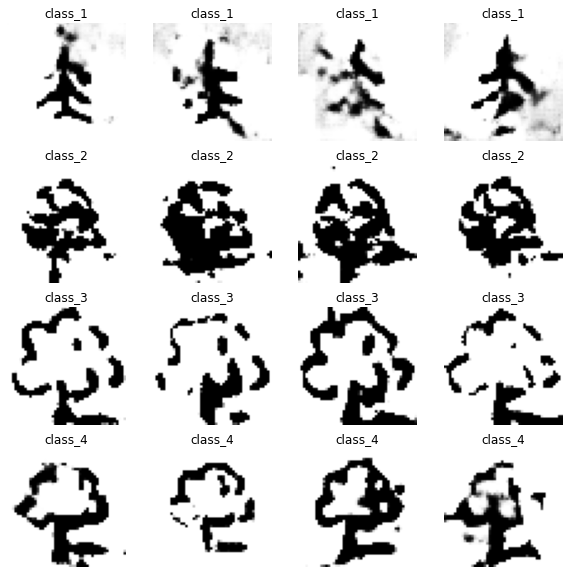

[77/100]	Loss_D: 0.2730	Loss_G: -0.1269
[78/100]	Loss_D: 0.1936	Loss_G: -0.1951
[79/100]	Loss_D: 0.2495	Loss_G: -0.1663
[80/100]	Loss_D: 0.1982	Loss_G: -0.2603
[81/100]	Loss_D: 0.2280	Loss_G: -0.2145


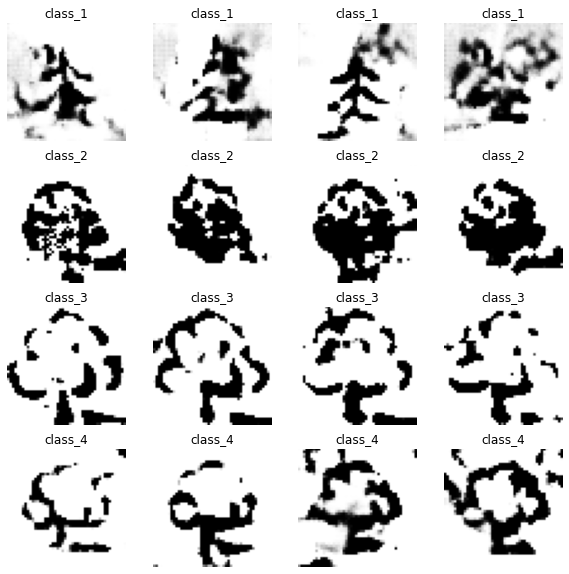

[82/100]	Loss_D: 0.2390	Loss_G: -0.3209
[83/100]	Loss_D: 0.2917	Loss_G: -0.1600
[84/100]	Loss_D: 0.2687	Loss_G: -0.0941
[85/100]	Loss_D: 0.2431	Loss_G: 0.0159
[86/100]	Loss_D: 0.2451	Loss_G: -0.2224


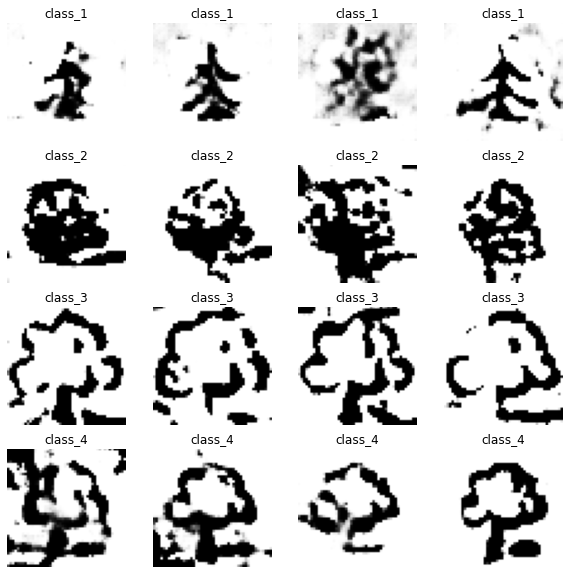

[87/100]	Loss_D: 0.2248	Loss_G: -0.3574
[88/100]	Loss_D: 0.2748	Loss_G: -0.3098
[89/100]	Loss_D: 0.2197	Loss_G: -0.0072
[90/100]	Loss_D: 0.2731	Loss_G: -0.2531
[91/100]	Loss_D: 0.2866	Loss_G: -0.1006


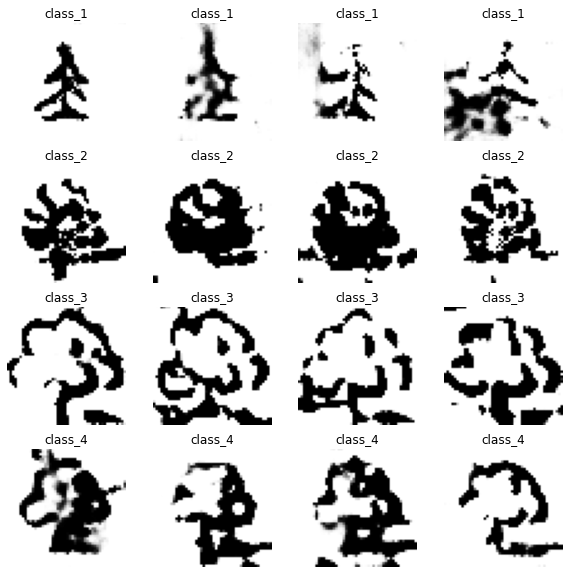

[92/100]	Loss_D: 0.2416	Loss_G: -0.2586
[93/100]	Loss_D: 0.2378	Loss_G: -0.3556
[94/100]	Loss_D: 0.2325	Loss_G: -0.1051
[95/100]	Loss_D: 0.2208	Loss_G: -0.1191
[96/100]	Loss_D: 0.2675	Loss_G: -0.2479


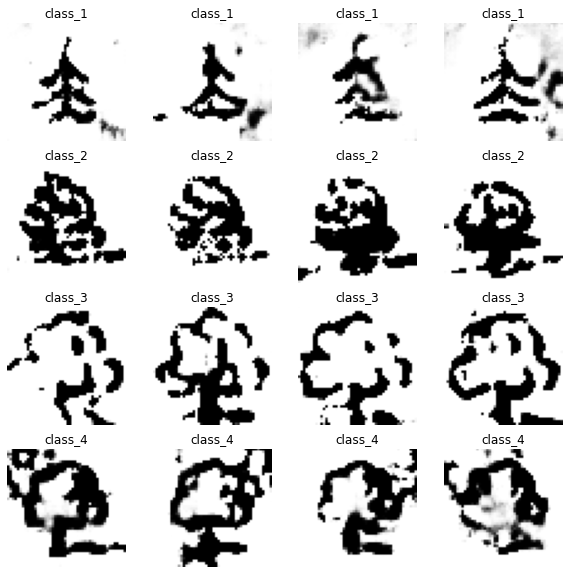

[97/100]	Loss_D: 0.2415	Loss_G: -0.1970
[98/100]	Loss_D: 0.2322	Loss_G: -0.2843
[99/100]	Loss_D: 0.2125	Loss_G: -0.2228
[100/100]	Loss_D: 0.2436	Loss_G: -0.1825


In [68]:
num_epochs = 100 # Number of training epochs
lr = 0.0002 # Learning rate for optimizers
beta1 = 0.5 # Beta1 hyperparam for Adam optimizers
clip_value = 0.01
n_critic = 5

# Establish convention for real and fake labels during training
# real_label = -1.
# fake_label = 1.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999), maximize=True)
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999), maximize=True)

# Training Loop
print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, (images,labels) in enumerate(dataloader, 0):
        ############################
        # (1) Update D network:
        ###########################

        ## Prepare all-real batch
        netD.zero_grad()
        # Format batch
        real_images = images.to(device)
        real_class_labels = labels.to(device)

        ## Prepare all-fake batch
        # Generate batch of latent vectors
        z = torch.randn(batch_size, nz, 1, 1, device=device)
        # Generate set of labels
        fake_class_labels = torch.randint(len(dataset.classes), (batch_size,), device=device)
        # Generate fake image batch with G
        fake_images = netG(z, fake_class_labels)

        ## Adversarial loss
        errD = torch.mean(netD(fake_images, fake_class_labels)) - torch.mean(netD(real_images, real_class_labels))
        errD.backward()
        optimizerD.step()

        # Clip weights of discriminator
        for p in netD.parameters():
            p.data.clamp_(-clip_value, clip_value)
        

        ############################
        # (2) Update G network every 5 epochs
        ###########################
        if i % n_critic == 0:
          # train Generator
          netG.zero_grad()
          # generate a batch of fake images
          fake_images = netG(z, fake_class_labels)
          # Adversarial loss
          errG = -torch.mean(netD(fake_images, fake_class_labels))
          errG.backward()
          optimizerG.step()

        # Output training stats
        if i+1 == len(dataloader):
            print('[%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f'
                  % (epoch+1, num_epochs,
                    errD.item(), errG.item()))
            
    # Save images
    if epoch % 5 == 0:
        figure = plt.figure(figsize=(10, 10))
        for c in range(len(dataset.classes)):
          zs = torch.randn(4, nz, 1, 1, device=device)
          netG.eval()
          images = netG(zs, torch.tensor([c]*4, device=device)).cpu().detach()

          for i in range(4):
            figure.add_subplot(4, 4, (c*4)+i+1)
            plt.title(dataset.classes[c])
            plt.axis("off")
            plt.imshow(-images[i,:].squeeze(), cmap="gray")

        plt.show()

## Generate Random Samples

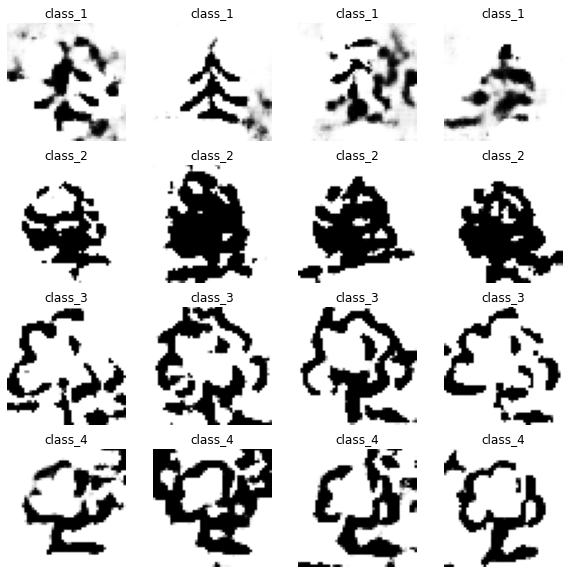

In [69]:
figure = plt.figure(figsize=(10, 10))

for c in range(len(dataset.classes)):
  zs = torch.randn(4, nz, 1, 1, device=device)
  netG.eval()
  images = netG(zs, torch.tensor([c]*4, device=device)).cpu().detach()

  for i in range(4):
    figure.add_subplot(4, 4, (c*4)+i+1)
    plt.title(dataset.classes[c])
    plt.axis("off")
    plt.imshow(-images[i,:].squeeze(), cmap="gray")

plt.show()

The original generated samples unfortunately do not show any noticable variation (though a small amount did exist).  Attempts were made to rectify this, by introducing rotational randomness to the dataset, and also by attempting an implementation of the packing / PacGAN , but unfortunately neither process resulted in usable results.  The rotational randomness simply created images more akin to snowflakes or flowers than trees, perhaps attempting to replicate the distinctive features of each class at every possible angle.  The PacGAN attempts simply resulted in noisier images, perhaps slowing the time taken for a clear image to form.

Adopting the WGAN method of a Wasserstein loss improved results to the point that within approximately 30 epochs distinctive tree shapes were visible, and each image in the sample had clear variations from the others.

## Interpolation Between Samples

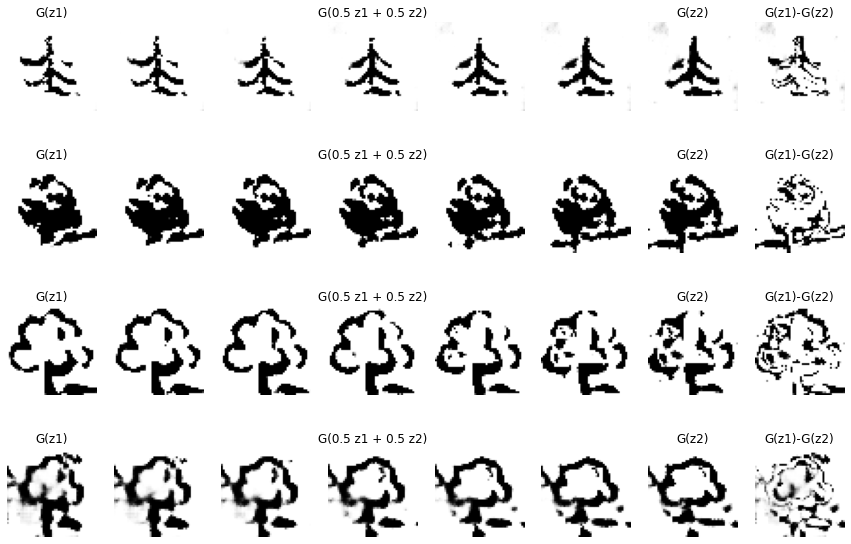

In [70]:
figure = plt.figure(figsize=(15, 10))

for c in range(len(dataset.classes)):
  zs = torch.randn(7, nz, 1, 1, device=device)
  z1 = zs[0]
  z2 = zs[6]
  labels = ["G(z1)", "", "", "G(0.5 z1 + 0.5 z2)", "", "", "G(z2)", "G(z1)-G(z2)"]

  for i in range(7):
    z2prop = (1/6) * i
    z1prop = 1-z2prop
    zs[i] = z1*z1prop + z2*z2prop

  netG.eval()
  images = netG(zs, torch.tensor([c]*7, device=device)).cpu().detach()

  for i in range(7):
    figure.add_subplot(4, 8, (c*8)+i+1)
    plt.title(labels[i])
    plt.axis("off")
    plt.imshow(-images[i,:].squeeze(), cmap="gray")

  figure.add_subplot(4, 8, (c*8)+8)
  plt.title("G(z1)-G(z2)")
  plt.axis("off")
  plt.imshow(-abs(images[6,:]-images[0,:]).squeeze(), cmap="gray")
plt.show()

Out of interest, I included an 8th image showing the difference between the images generated using z1 and z2.